# Setup

## Colab

In [2]:
# Mount the drive and move to dir
from google.colab import drive
drive.mount("/content/drive", force_remount = False)
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [ ]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
# from classes.models import BertGridNew

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertGridNew)

# Import the model and funcs required from utils
# from classes.models.BertGridNew import BertGridNew
from utils.inferutil import infer_full, infer_one
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/

In [ ]:
# Restart
from utils import setuputil

importlib.reload(setuputil)
from utils.setuputil import display_config, setup_config

# # Setup the config
# input_config = {
#     # Environment and Model Info
#     "env": "colab",
#     "approach": "bert",
#     "model_name": "BertPreTiny",
#     "model_base": "prajjwal1/bert-tiny",
#     "data_ds": "manual",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 128,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 512,
#     # Training Parameters
#     "batch_size": 4,
#     "lr": 1e-2,
#     "mu": 0.25,
#     "epochs": 20,
#     "patience": 2,
#     "save_int": 0,
# }

input_config = {
    # Environment and Model Info
    "env": "local",
    "approach": "bert",
    "model_name": "BertPreTiny",
    "model_base": "prajjwal1/bert-tiny",
    "data_ds": "manual",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 512,
    "gradient_checkpointing": False,
    # Training Parameters
    "batch_size": 4,
    "lr": 1e-3,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 0,
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:04<00:00,  8.20it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 8493.93it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 12278.41it/s]



5(P) = 5(G) + 0(E)

FINAL CONFIG:
{
  "env": "local",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 8,
  "seed": 0,
  "model_base": "prajjwal1/bert-tiny",
  "model_name": "BertPreTiny",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 128,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 512,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 4,
  "lr": 0.001,
  "mu": 0.25,
  "epochs": 10,
  "pa

# NEW TESTER

## Model Creation -> Single Example Check

In [ ]:
# Imports
import math

import torch
import torch.nn as nn
from transformers import AutoModel, BertConfig
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertPreTinyNew class
class BertPreTinyNew(nn.Module):
    """A BERT-based model that combines positional and content understanding for grid-structured data.

    This model processes grid-structured input through BERT embeddings enriched with positional
    encodings for both row and column positions. It uses a combination of BERT encoding and
    positional information to create a rich representation of grid cells.

    Args:
        config (dict): Configuration dictionary containing model parameters.
    """

    def __init__(self, config):
        super().__init__()

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Pretrained model for cell's text content and its variables
        self.bertModel_cell = AutoModel.from_pretrained(config["model_base"])

        # Store the hidden size of the pretrained BERT model
        self.pre_hidden_size = self.bertModel_cell.config.hidden_size

        # Project pretrained bert-tiny to our hidden size if different, else use Identity
        self.proj_spatial = (
            nn.Identity()
            if self.bertModel_cell.config.hidden_size == self.hidden_size
            else nn.Linear(self.bertModel_cell.config.hidden_size, self.hidden_size)
        )

        # Custom encoder for row/col position information
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute positional encodings for grid cells
        self.pos_encodings = self.get_posEncoding(self.rows, self.cols)

        # Final binary classification layers
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    def get_posEncoding(self, num_rows, num_cols):
        """Generates optimized positional encodings for grid cells using BertGridNew's approach.

        Uses sinusoidal functions with broadcasting and combined calculations to efficiently compute
        positional encodings while preserving the mathematical properties but adapted for pretrained
        model dimensions.

        Args:
            num_rows (int): The number of rows in the grid.
            num_cols (int): The number of columns in the grid.

        Returns:
            torch.Tensor: A tensor of shape [1, num_rows * num_cols, pre_hidden_size] containing
                        the positional encodings.
        """
        # Calculate all position indices at once to get row/col indices
        positions = torch.arange(num_rows * num_cols, device=self.device)
        i = positions // num_cols  # row indices
        j = positions % num_cols  # column indices

        # Create hidden dimension vector for frequency calculations
        # Adjusted for pre_hidden_size instead of hidden_size
        frequency_base = 8.0 * (
            torch.arange(self.pre_hidden_size, device=self.device) + (j[:, None] % 2)
        )

        # Return [1, rows * cols, pre_hidden_size] tensor with formula
        return (
            (torch.sin(i[:, None] / (10 ** (frequency_base / num_rows))))
            + (torch.sin(j[:, None] / (10 ** (frequency_base / num_cols))))
        ).unsqueeze(0)

    def forward(self, input_ids, attention_mask):
        """Process input through the model to generate grid cell representations.

        This method reshapes the input tokens for each grid cell, obtains BERT embeddings
        for the cells, and enriches them with our optimized positional encodings before
        passing through the spatial encoder and classifier.

        Args:
            input_ids (torch.Tensor): Tensor of token IDs [batch_size, rows, cols, seq_len]
            attention_mask (torch.Tensor): Tensor of attention masks [batch_size, rows, cols, seq_len]

        Returns:
            torch.Tensor: Tensor of shape [batch_size, rows, cols] containing the binary
                        classification outputs for each grid cell.
        """
        # Retrieve dimensions
        batch_size, rows, cols, seq_len = input_ids.shape

        # Generate the S_cube with optimized ordering of operations
        return (
            self.binary_classifier(
                self.bertEncoder_spatial(
                    self.proj_spatial(
                        # First get BERT embeddings and reshape
                        self.bertModel_cell(
                            input_ids=input_ids.reshape(-1, seq_len),
                            attention_mask=attention_mask.reshape(-1, seq_len),
                        ).pooler_output.reshape(
                            batch_size, rows * cols, self.pre_hidden_size
                        )
                        # Add positional encodings before projection
                        + self.pos_encodings.to(input_ids.device)
                    )
                )[0]
            )
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

In [4]:
import importlib
import time

from utils import selfutil

importlib.reload(selfutil)

from utils.selfutil import compare_sCube, oneBatch_check

ex_file, ex_xtok, ex_xmasks, ex_ytok = oneBatch_check(
    batch_size=5, data_loader=train_loader, device=DEVICE
)

untrained_model = BertPreTinyNew(config).to(DEVICE)
untrained_model.eval()

with torch.no_grad():
    # start_time_forward2 = time.time()
    # out2 = untrained_model.forward2(ex_xtok, ex_xmasks)
    # elapsed_forward2 = time.time() - start_time_forward2
    # print(f"NEW forward2: {elapsed_forward2:.3f} seconds")

    start_time_forward = time.time()
    out = untrained_model.forward(ex_xtok, ex_xmasks)
    elapsed_forward = time.time() - start_time_forward
    print(f"OLD forward: {elapsed_forward:.3f} seconds")

# compare_sCube(out, out2, ex_file, tolerance=1e-6)

Filenames:	['../data/manual_train/idrportfolio-by-debt-size.xls', '../data/manual_train/dlportfoliobydelinquencystatus.xls', '../data/manual_train/dlportfolio-by-debt-size.xls', '../data/manual_train/harassment-bullying-on-basis-of-race-reported copy.xlsx', '../data/manual_train/dlportfolio-by-age.xls']
Tok Tensor Shapes:	torch.Size([5, 100, 100, 32]),	torch.Size([5, 100, 100, 17])

OLD forward: 0.435 seconds


# Model Training

In [ ]:
# Create and observe the model
untrained_model = BertPreTiny(config).to(DEVICE)
# print(untrained_model)

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

## Training Metrics

1. GPU Model: 539 mb
2. GPU Training: 36.7 gb

3. Per Epoch Train Time: 38s
4. Per Epoch Val Time: 15s
5. Last Epoch: 16


In [ ]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
    # isPerp=True,
)

Epoch 0


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 1.6170e+00, Val Loss: 1.5562e+00


Epoch 1


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 1.0691e+00, Val Loss: 9.3514e-01


Epoch 2


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 6.3208e-01, Val Loss: 3.2609e-01


Epoch 3


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Train Loss: 3.1597e-01, Val Loss: 4.5564e-02


Epoch 4


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Train Loss: 8.7090e-02, Val Loss: 1.0784e-02


Epoch 5


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 1.5754e-02, Val Loss: 1.0359e-02


Epoch 6


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Train Loss: 1.2061e-02, Val Loss: 6.9610e-03


Epoch 7


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


Train Loss: 1.0300e-02, Val Loss: 5.9542e-03


Epoch 8


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Train Loss: 4.1137e-03, Val Loss: 5.4313e-03


Epoch 9


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 3.1967e-03, Val Loss: 5.1742e-03


Epoch 10


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 2.6653e-03, Val Loss: 5.0149e-03


Epoch 11


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 3.5045e-03, Val Loss: 4.8262e-03


Epoch 12


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 6.3982e-03, Val Loss: 4.9037e-03


Epoch 13


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Train Loss: 2.2725e-03, Val Loss: 4.7739e-03


Epoch 14


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 1.9271e-03, Val Loss: 4.7241e-03


Epoch 15


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Train Loss: 1.7085e-03, Val Loss: 4.6971e-03


Epoch 16


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 1.5621e-03, Val Loss: 4.6566e-03


Epoch 17


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Train Loss: 1.4308e-03, Val Loss: 4.5300e-03


Epoch 18


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


Train Loss: 3.6712e-03, Val Loss: 4.7667e-03


Epoch 19


Validation Processing: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

Train Loss: 1.5491e-03, Val Loss: 4.7269e-03


EARLY STOPPING at epoch 19, best epoch 17
Train Loss = 1.4308e-03, Val Loss = 4.5300e-03


TRAINING DONE at epoch 19, best epoch 17
Train Loss = 0.0014307816629298032, Perplexity = 1.0000000357695422
Val Loss = 0.004530034406343475, Perplexity = 1.0000001132508665


# Evaluation

In [ ]:
# Params
loc = 0
thresh = 0.99
infer_batch_size = batch_size

# # Load the pretrained weights and assign to trained model
# untrained_model.load_state_dict(
#     torch.load(
#         "../models/ber0c_bbcBertPos_manual10010032_ba40lr1e-2ep20pa2_v30kh32l1i128a1_20250210_210415.pth",
#         map_location=DEVICE,
#         weights_only=True,
#     )
# )
# trained_model = untrained_model.eval()

## Single Example


Filename: ../data/manual_train/dlportfoliobydelinquencystatus.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(39,13): 0.999468 | (39,10): 0.999484 | (39,9): 0.999488 | (39,12): 0.999492 | (39,11): 0.999496 | (39,8): 0.999528 | (39,7): 0.999583 | (39,0): 0.999614 | (39,1): 0.999620 | (39,6): 0.999625 | (39,2): 0.999627 | (37,0): 0.999634 | (39,3): 0.999639 | (36,0): 0.999645 | (39,5): 0.999647 | (37,1): 0.999649 | (39,4): 0.999650 | (29,0): 0.999654 | (35,0): 0.999654 | (25,0): 0.999655 | (30,0): 0.999655 | (24,0): 0.999657 | (28,0): 0.999658 | (26,0): 0.999659 | (23,0): 0.999659 | (36,1): 0.999660 | (34,0): 0.999660 | (22,0): 0.999660 | (27,0): 0.999663 | (33,0): 0.999663 | (21,0): 0.999664 | (29,1): 0.999667 | (28,1): 0.999668 | (0,0): 0.999669 | (22,1): 0.999669 | (34,1): 0.999670 | (30,1): 0.999670 | (20,0): 0.999671 | (33,1): 0.999671 | (23,1): 0.999672 | (21,1): 0.999672 | (32,1): 0.999672 | (24,1): 0.999672 | (31,1): 0.999673 | (26,1): 0.999673 | (27,1): 0.999673 | (19

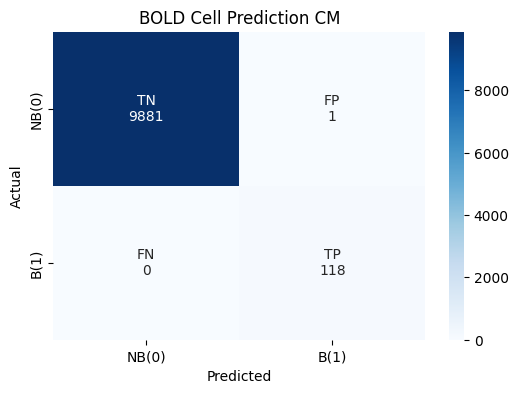


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(29,0): 0.999654 | (25,0): 0.999655 | (30,0): 0.999656 | (24,0): 0.999657 | (28,0): 0.999658 | (26,0): 0.999659 | (23,0): 0.999659 | (31,0): 0.999660 | (22,0): 0.999660 | (27,0): 0.999662 | (32,0): 0.999663 | (21,0): 0.999664 | (29,1): 0.999667 | (0,0): 0.999667 | (22,1): 0.999669 | (30,1): 0.999670 | (20,0): 0.999671 | (23,1): 0.999671 | (25,1): 0.999672 | (21,1): 0.999672 | (31,1): 0.999672 | (24,1): 0.999673 | (32,1): 0.999673 | (26,1): 0.999673 | (19,0): 0.999677 | (6,8): 0.999677 | (20,1): 0.999680 | (0,1): 0.999680 | (6,7): 0.999680 | (18,0): 0.999682 | (6,9): 0.999683 | (8,0): 0.999684 | (9,0): 0.999684 | (0,17): 0.999684 | (0,8): 0.999685 | (0,9): 0.999685 | (16,0): 0.999687 | (0,16): 0.999687 | (19,1): 0.999688 | (6,17): 0.999689 | (6,16): 0.999690 | (10,0): 0.999691 | (15,0): 0.999691 | (0,15): 0.999691 | (7,0): 0.999691 | (6,6): 0.999691 | (0,10): 0.999692 | (6,15): 0.9

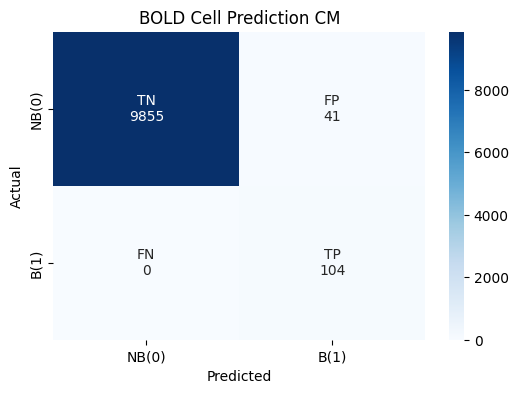


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,9): 0.001040 | (5,8): 0.001452 | (5,7): 0.997000 | (5,6): 0.998070 | (38,0): 0.999623 | (37,0): 0.999634 | (38,1): 0.999635 | (36,0): 0.999645 | (37,1): 0.999648 | (29,0): 0.999654 | (35,0): 0.999654 | (25,0): 0.999655 | (30,0): 0.999655 | (24,0): 0.999657 | (28,0): 0.999659 | (26,0): 0.999659 | (23,0): 0.999659 | (34,0): 0.999660 | (36,1): 0.999660 | (22,0): 0.999660 | (32,0): 0.999662 | (27,0): 0.999663 | (33,0): 0.999663 | (21,0): 0.999664 | (0,21): 0.999666 | (35,1): 0.999667 | (28,1): 0.999669 | (22,1): 0.999669 | (0,0): 0.999670 | (33,1): 0.999671 | (25,1): 0.999671 | (21,1): 0.999671 | (23,1): 0.999672 | (0,20): 0.999672 | (24,1): 0.999673 | (32,1): 0.999673 | (31,1): 0.999673 | (26,1): 0.999673 | (27,1): 0.999673 | (6,21): 0.999674 | (19,0): 0.999676 | (6,8): 0.999677 | (0,19): 0.999679 | (20,1): 0.999679 | (6,20): 0.999680 | (6,7): 0.999680 | (18,0): 0.999681 |

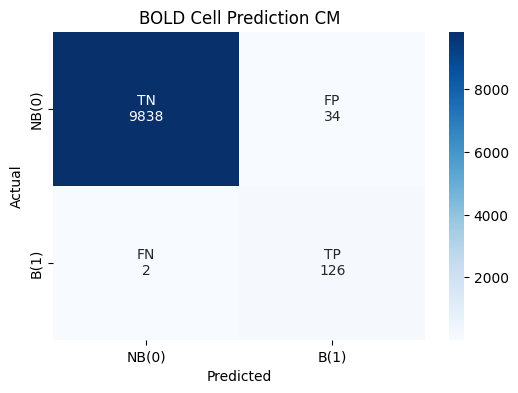


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)

## All Examples

Batch Inference: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396685:3315 | Actual = 396714:3286
Accuracy: 99.99% | Precision: 99.22% | Recall: 100.00% | F1-Score: 1.00



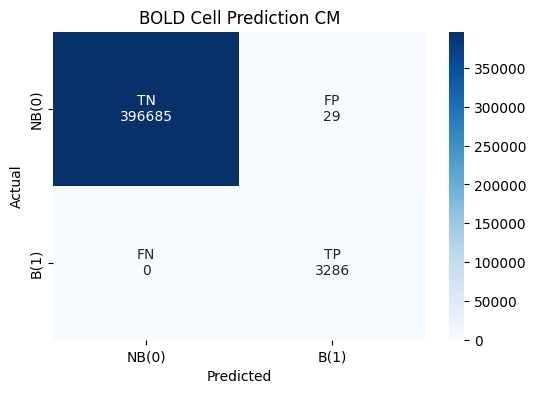

In [ ]:
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49559:441 | Actual = 49602:398
Accuracy: 99.95% | Precision: 94.20% | Recall: 100.00% | F1-Score: 0.97



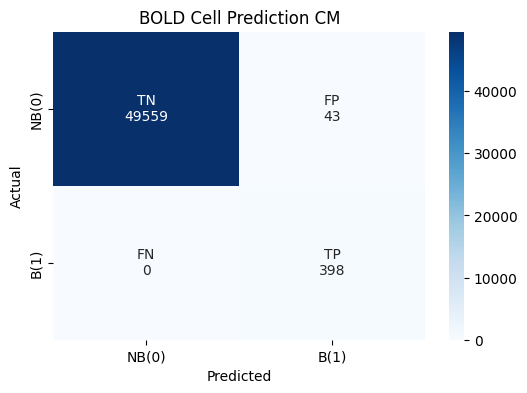

In [ ]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49571:429 | Actual = 49606:394
Accuracy: 99.95% | Precision: 94.95% | Recall: 99.70% | F1-Score: 0.97



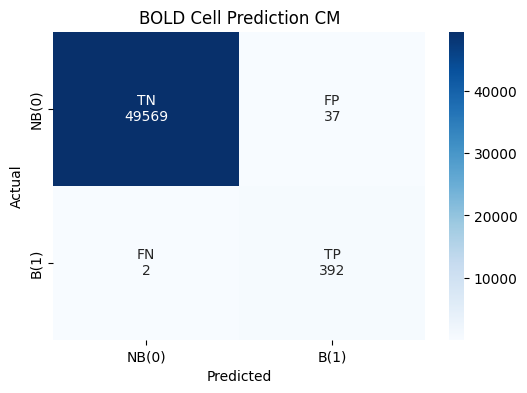

In [ ]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)